In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from network_revised import DotPerception, build_network

In [2]:
palette = sns.color_palette("colorblind")
palette2 = sns.color_palette("tab10")[2:4]
palette3 = sns.color_palette("viridis", 10)
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [3]:
def single_trial(coherence, nActions, ramp=1, relative=0, threshold=0.5, perception_seed=0, network_seed=0,
                 max_rates=nengo.dists.Uniform(100, 200), dt=0.001, dt_sample=0.01, tmax=5, sigma=0.3, nNeurons=500, rA=4, legend=True, name="single"):

    inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
    inputs.create(coherence=coherence)
    net = build_network(inputs, nNeurons=nNeurons, nActions=nActions, seed=network_seed, ramp=ramp, threshold=threshold,
                        relative=relative, rA=rA, max_rates=max_rates)
    sim = nengo.Simulator(net, progress_bar=False)
    choice = None
    RT = None
    while choice==None:
        sim.run(dt)
        if np.any(sim.data[net.pAction][-1,:] > 0.01):
            choice = np.argmax(sim.data[net.pAction][-1,:])
            RT = sim.trange()[-1]
        if sim.trange()[-1] > tmax:
            choice = np.argmax(sim.data[net.pValue][-1,:])
            RT = sim.trange()[-1]
        correct = 1 if choice==net.inputs.correct else 0
    print(RT)
    # print(inputs.motions)
    # print(choice, net.inputs.correct)

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=((7, 2.5)))
    for a in range(nActions):
        axes[0].plot(sim.trange(), sim.data[net.pAccumulator][:,a], color=palette[a], label=f"Estimate {a}", lw=0.5) 
        axes[1].plot(sim.trange(), sim.data[net.pValue][:,a], color=palette[a], label=f"Value {a}") 
    for a in range(nActions):
        if dt_sample is not None:
            ideal = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
            axes[0].plot(sim.trange(), ideal, color=palette[a], label=f"True {a}", linestyle="--") 
#     axes[1].plot(sim.trange(), sim.data[net.pGate], label='threshold', color="black")
    axes[1].plot(sim.trange(), net.threshold*np.ones_like(sim.trange()), label='Threshold', color="red", linestyle=":")
    axes[0].set(ylabel=r"$\mathbf{M}(t)$", xlabel="Time (s)", title=f"Cumulative Motion (seed {perception_seed})")
    axes[1].set(ylabel=r"$\mathbf{V}(t)$", xlabel="Time (s)", title=r"Value ($L=$"+f"{relative})")
    if legend:
        axes[0].legend(loc='upper left', ncol=2)
        leg = axes[1].legend(loc='lower right')
        leg.get_texts()[choice].set_color("lime" if correct else "red")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

## Results

0.6890000000000001


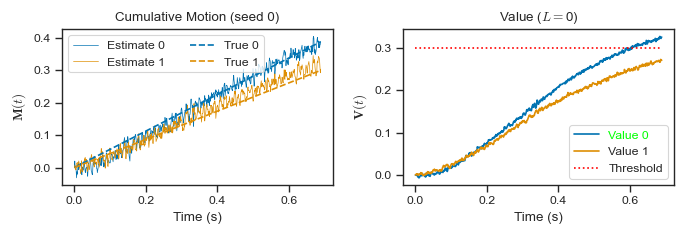

In [152]:
single_trial(coherence=0.128, nActions=2, ramp=1, threshold=0.3, relative=0, network_seed=0, perception_seed=0, rA=2.0, name="dynamics1")

0.764


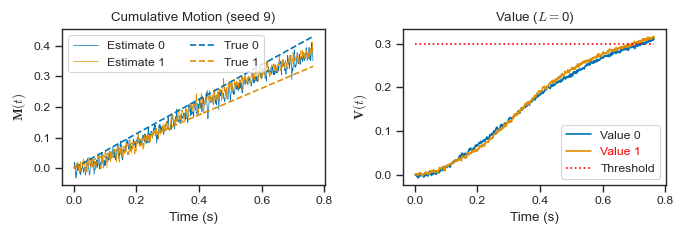

In [153]:
single_trial(coherence=0.128, nActions=2, ramp=1, threshold=0.3, relative=0, network_seed=0, perception_seed=9, rA=2.0, name="dynamics2")

2.718


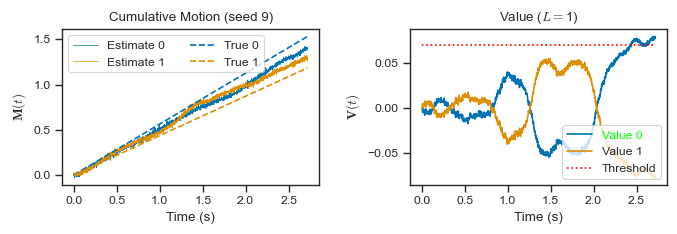

In [154]:
single_trial(coherence=0.128, nActions=2, ramp=1, threshold=0.07, relative=1, network_seed=0, perception_seed=9, rA=2.0, name="dynamics3")

0.879


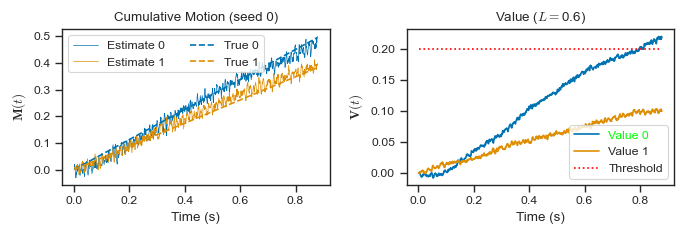

In [157]:
single_trial(coherence=0.128, nActions=2, ramp=1, threshold=0.2, relative=0.6, network_seed=0, perception_seed=0, rA=2.0, name="dynamics4")

1.165


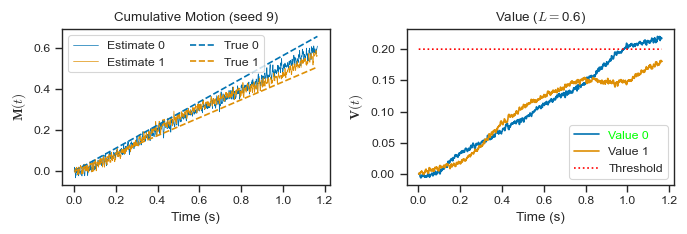

In [158]:
single_trial(coherence=0.128, nActions=2, ramp=1, threshold=0.2, relative=0.6, network_seed=0, perception_seed=9, rA=2.0, name="dynamics5")

### 2 vs 4 actions, identical parameters

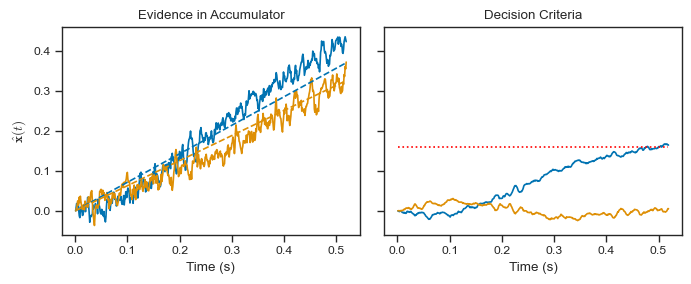

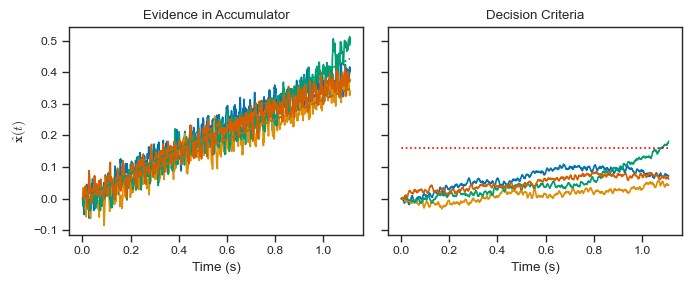

In [11]:
single_trial(coherence=0.064, ramp=1.34, relative=0.76, threshold=0.16, nActions=2, perception_seed=6, rA=2, nNeurons=1000, max_rates=nengo.dists.Uniform(70, 100))
single_trial(coherence=0.064, ramp=1.34, relative=0.76, threshold=0.16, nActions=4, perception_seed=6, rA=2, nNeurons=1000, max_rates=nengo.dists.Uniform(70, 100))

In [5]:
def multiple_trial(coherence,
                   trials=3,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   dt_sample=0.01,
                   sigma=0.3,
                   ramp=1,
                   threshold=0.5,
                   relative=0,
                   rA=4,
                   nActions=2,
                   nNeurons=500,
                   max_rates=nengo.dists.Uniform(100, 200),
                   tmax=5,
                   name="multiple_trials",
                   **kwargs):
    
    inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
    inputs.create(coherence=coherence, correct=0)  # force the correct choice to be zero on each trial
    dfs_dynamics = []
    for trial in range(trials):
        net = build_network(inputs, nActions=nActions, seed=trial, ramp=ramp, threshold=threshold, relative=relative, rA=rA,
                            max_rates=max_rates, nNeurons=nNeurons)
        sim = nengo.Simulator(net, progress_bar=False)
        choice = None
        RT = None
        while choice==None:
            sim.run(dt)
            if np.any(sim.data[net.pAction][-1,:] > 0.01):
                choice = np.argmax(sim.data[net.pAction][-1,:])
                RT = sim.trange()[-1]
            if sim.trange()[-1] > tmax:
                choice = np.argmax(sim.data[net.pValue][-1,:])
                RT = sim.trange()[-1]
        print(f"trial {trial}, coherence {coherence}, choice {choice}, correct {net.inputs.correct}, RT {RT}")
        correct = 1 if choice==net.inputs.correct else 0
        if choice is not None:
            correct = 1 if choice==net.inputs.correct else 0
            df = pd.DataFrame()
            df['coherence'] = coherence*np.ones_like(sim.trange())
            df['trial'] = trial*np.ones_like(sim.trange())
            df['threshold'] = threshold*np.ones_like(sim.trange())
            df['time'] = sim.trange()
            df['accuracy'] = 100*correct*np.ones_like(sim.trange())
            df['RT'] = 1000*RT*np.ones_like(sim.trange())
            for a in range(nActions):
                df[f'ideal {a}'] = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
                df[f'evidence {a}'] = sim.data[net.pAccumulator][:,a].ravel()
                df[f'value {a}'] = sim.data[net.pValue][:,a].ravel()
            dfs_dynamics.append(df)

    data = pd.concat(dfs_dynamics, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((3.5, 3)))
    subdata_correct = data.query("accuracy==100")
    subdata_incorrect = data.query("accuracy==0")
    if not subdata_correct.empty:
        sns.lineplot(data=subdata_correct, x='time', y='value 0', units='trial', estimator=None, lw=0.2, color=palette2[0], ax=ax)
    if not subdata_incorrect.empty:
        sns.lineplot(data=subdata_incorrect, x='time', y='value 0', units='trial', estimator=None, lw=0.2, color=palette2[1], ax=ax)
        # sns.lineplot(data=subdata_incorrect, x='time', y='value 1', units='trial', estimator=None, lw=0.2, color=palette2[0], ax=ax)
    sns.lineplot(data=data, x='time', y='ideal 0', color=palette[0], linestyle="--", estimator=None, ax=ax)
    sns.lineplot(data=data, x='time', y='threshold', color="red", linestyle=":", estimator=None, ax=ax)
    ax.set(xlabel="Time (s)", ylabel=r"$\hat{\mathbf{x}}(t)$", ylim=((-0.05, threshold+0.05)))
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.128, choice 0, correct 0, RT 2.5220000000000002


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.128, choice 1, correct 0, RT 2.363


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.128, choice 0, correct 0, RT 1.3980000000000001


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.128, choice 1, correct 0, RT 1.7770000000000001


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.128, choice 0, correct 0, RT 1.364


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.128, choice 0, correct 0, RT 1.832


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.128, choice 0, correct 0, RT 1.436


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.128, choice 1, correct 0, RT 2.4050000000000002


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.128, choice 0, correct 0, RT 1.498


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.128, choice 0, correct 0, RT 2.328


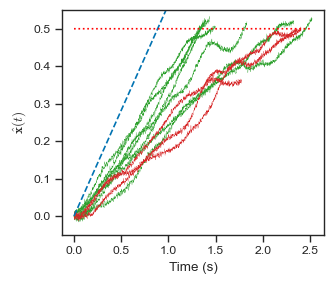

In [8]:
multiple_trial(coherence=0.128, ramp=1, threshold=0.5, relative=0.5, rA=2.0, trials=10, perception_seed=0)

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.128, choice 1, correct 0, RT 0.9560000000000001


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.128, choice 1, correct 0, RT 1.115


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.128, choice 1, correct 0, RT 1.1420000000000001


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.128, choice 1, correct 0, RT 1.137


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.128, choice 0, correct 0, RT 1.04


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.128, choice 1, correct 0, RT 1.079


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.128, choice 1, correct 0, RT 1.016


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.128, choice 1, correct 0, RT 0.974


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.128, choice 1, correct 0, RT 1.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.128, choice 1, correct 0, RT 1.032


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 10, coherence 0.128, choice 1, correct 0, RT 1.077


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 11, coherence 0.128, choice 1, correct 0, RT 1.135


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 12, coherence 0.128, choice 1, correct 0, RT 1.039


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 13, coherence 0.128, choice 1, correct 0, RT 1.038


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 14, coherence 0.128, choice 1, correct 0, RT 1.096


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 15, coherence 0.128, choice 1, correct 0, RT 0.971


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 16, coherence 0.128, choice 1, correct 0, RT 1.07


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 17, coherence 0.128, choice 1, correct 0, RT 1.104


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 18, coherence 0.128, choice 1, correct 0, RT 1.0190000000000001


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 19, coherence 0.128, choice 1, correct 0, RT 1.116


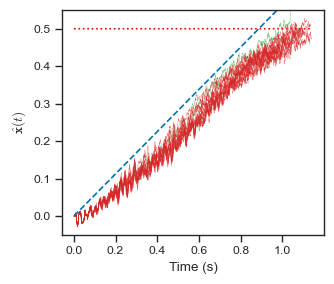

In [23]:
multiple_trial(coherence=0.128, trials=20, perception_seed=0, max_rates=nengo.dists.Uniform(70, 100))

In [18]:
def scan_dtsample_sigma(
        coherence,
        dt_samples,
        sigmas,
        trials=10,
        perception_seed=0,
        network_seed=0,
        dt=0.001,
        ramp=1,
        threshold=0.5,
        relative=0,
        nNeurons=500,
        rA=4,
        nActions=2,
        tmax=5,
        set_correct=0,
        max_rates=nengo.dists.Uniform(100, 200),
        name="scan_dtsample_sigma",
        bins = np.arange(0.0, 2.0, 0.2),
        load=False):

    ts_string = r"$t_s$"
    sigma_string = r"$\sigma$"
    if not load:
        dfs = []
        dfs2 = []
        for dt_sample in dt_samples:
            for sigma in sigmas:
                inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
                inputs.create(coherence=coherence, correct=set_correct)  # force the correct choice to be "zero" on each trial
                for trial in range(trials):
                    print(f"trial {trial}, coherence {coherence}, dt_sample {dt_sample}, sigma {sigma}")
                    # net = build_network(inputs, nActions=nActions, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative, rA=rA, nNeurons=nNeurons)
                    net = build_network(inputs, nActions=nActions, seed=trial, ramp=ramp, threshold=threshold, relative=relative, rA=rA,
                                        nNeurons=nNeurons, max_rates=max_rates)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    RT = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0.01):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > tmax:
                            choice = np.argmax(sim.data[net.pValue][-1,:])
                            RT = sim.trange()[-1]
                    # correct = 1 if choice==net.inputs.correct else 0
                    correct = 1 if choice==set_correct else 0
                    df = pd.DataFrame()
                    df['coherence'] = coherence*np.ones_like(sim.trange())
                    df['trial'] = trial*np.ones_like(sim.trange())
                    df['threshold'] = threshold*np.ones_like(sim.trange())
                    df[ts_string] = dt_sample*np.ones_like(sim.trange())
                    df[sigma_string] = sigma*np.ones_like(sim.trange())
                    df['time'] = sim.trange()
                    df['accuracy'] = 100*correct*np.ones_like(sim.trange())
                    df['RT'] = RT*np.ones_like(sim.trange())
                    for a in range(nActions):
                        df[f'ideal {a}'] = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
                        df[f'evidence {a}'] = sim.data[net.pAccumulator][:,a].ravel()
                        df[f'value {a}'] = sim.data[net.pValue][:,a].ravel()
                    dfs.append(df)
                    dfs2.append(pd.DataFrame([[trial, f"{coherence}", f"{dt_sample}", f"{sigma}", RT, 100*correct]],
                                             columns=('trial', 'coherence', ts_string, sigma_string, 'RT', 'accuracy')))
        data = pd.concat(dfs, ignore_index=True)
        data2 = pd.concat(dfs2, ignore_index=True)
        data.to_pickle(f"data/{name}.pkl")
        data2.to_pickle(f"data/{name}_result.pkl")

    else:
        data = pd.read_pickle(f"data/{name}.pkl")
        data2 = pd.read_pickle(f"data/{name}_result.pkl")

    fig = sns.FacetGrid(data, row=ts_string, col=sigma_string, hue='accuracy', hue_order=[100, 0],
                        palette=palette[:2], height=1.3, aspect=1.5, sharex=True, legend_out=True)
    fig.map_dataframe(sns.lineplot, x="time", y='value 0', units='trial', estimator=None, lw=0.4)
    fig.add_legend()
    fig.set_ylabels(r"$V_0(t)$")
    fig.set(yticks=[0.0, threshold])
    fig.set_xlabels("Time (s)")
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

    fig = sns.FacetGrid(data, row=ts_string, col=sigma_string, palette=palette[0], height=1.3, aspect=1.5, sharex=True)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", bins=bins, common_norm=False)
    fig.add_legend()
    fig.set(xticks=bins[::2])
    fig.set_ylabels("Percent")
    fig.set_xlabels("Response Time (s)")
    fig.savefig(f"plots/{name}_RT_distributions.svg")
    fig.savefig(f"plots/{name}_RT_distributions.png", dpi=600)

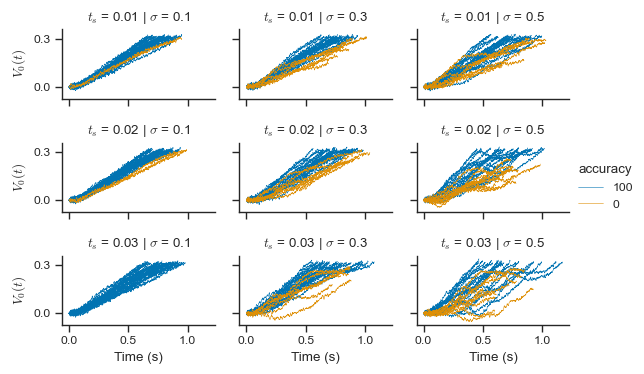

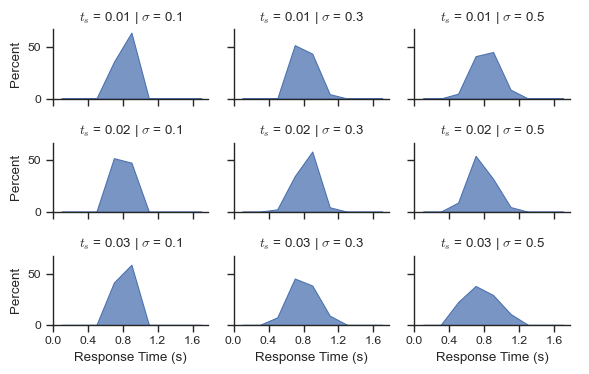

In [19]:
scan_dtsample_sigma(coherence=0.064, ramp=1.5, threshold=0.3, relative=0.5, rA=1.5, nNeurons=500, max_rates=nengo.dists.Uniform(80, 100),
                    dt_samples=[0.01, 0.02, 0.03], sigmas=[0.1, 0.3, 0.5], trials=30, load=True)

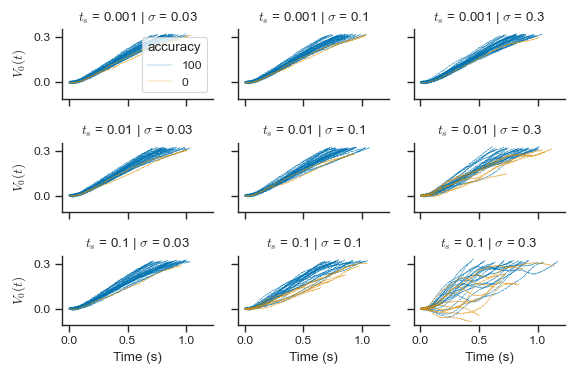

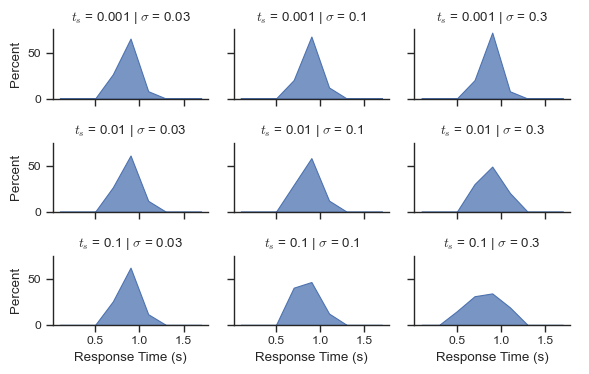

In [64]:
scan_dtsample_sigma(coherence=0.064, ramp=1.5, threshold=0.3, relative=0.5, rA=1.5,
                    dt_samples=[0.001, 0.01, 0.1], sigmas=[0.03, 0.1, 0.3], trials=30, load=True, name='ra15')

trial 0, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 10, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 11, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 12, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 13, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 14, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 15, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 16, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 17, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 18, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 19, coherence 0.064, dt_sample 0.001, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 10, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 11, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 12, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 13, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 14, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 15, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 16, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 17, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 18, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 19, coherence 0.064, dt_sample 0.001, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 10, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 11, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 12, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 13, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 14, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 15, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 16, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 17, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 18, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 19, coherence 0.064, dt_sample 0.001, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 10, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 11, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 12, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 13, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 14, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 15, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 16, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 17, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 18, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 19, coherence 0.064, dt_sample 0.01, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 10, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 11, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 12, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 13, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 14, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 15, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 16, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 17, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 18, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 19, coherence 0.064, dt_sample 0.01, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 10, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 11, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 12, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 13, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 14, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 15, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 16, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 17, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 18, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 19, coherence 0.064, dt_sample 0.01, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 10, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 11, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 12, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 13, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 14, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 15, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 16, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 17, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 18, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 19, coherence 0.064, dt_sample 0.1, sigma 0.03


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 10, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 11, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 12, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 13, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 14, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 15, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 16, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 17, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 18, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 19, coherence 0.064, dt_sample 0.1, sigma 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 0, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 1, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 2, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 3, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 4, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 5, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 6, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 7, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 8, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 9, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 10, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 11, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 12, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 13, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 14, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 15, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 16, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 17, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 18, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


trial 19, coherence 0.064, dt_sample 0.1, sigma 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


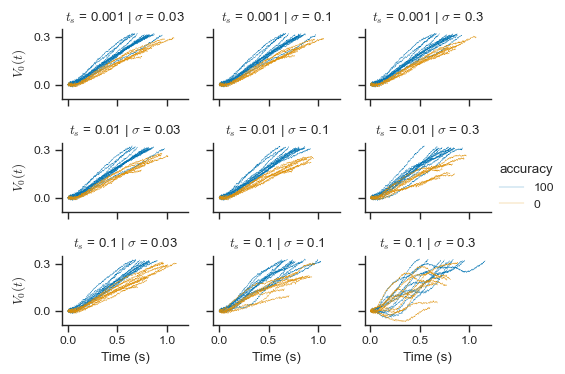

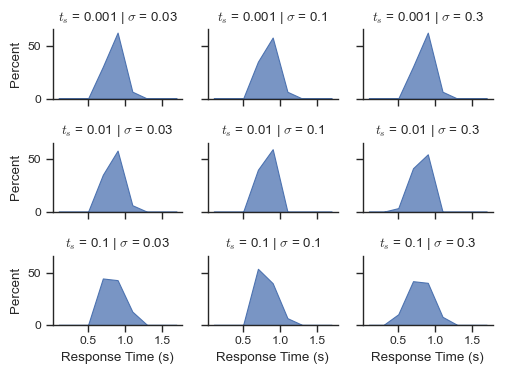

In [61]:
scan_dtsample_sigma(coherence=0.064, ramp=1.5, threshold=0.3, relative=0.5, rA=3,
                    dt_samples=[0.001, 0.01, 0.1], sigmas=[0.03, 0.1, 0.3], trials=20, load=False, name='ra3')

In [57]:
def absolute_vs_relative(coherence,
                   relatives=[0.0, 0.7, 1.0],
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   ramp=1,
                   threshold=0.5,
                   nActions=2,
                   sigma=0.3,
                   tmax=5,
                   dt_sample=0.01,
                   rA=4,
                   nNeurons=500,
                   name="absolute_vs_relative",
                   **kwargs):
    
    dfs = []
    for relative in relatives:
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        inputs.create(coherence=coherence)
        net = build_network(inputs, nActions=nActions, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative, rA=rA, nNeurons=nNeurons)
        sim = nengo.Simulator(net, progress_bar=False)
        choice = None
        RT = None
        while choice==None:
            sim.run(dt)
            if np.any(sim.data[net.pAction][-1,:] > 0.01):
                choice = np.argmax(sim.data[net.pAction][-1,:])
                RT = sim.trange()[-1]
            if sim.trange()[-1] > tmax:
                choice = np.argmax(sim.data[net.pValue][-1,:])
                RT = sim.trange()[-1]
        correct = 1 if choice==net.inputs.correct else 0
        df = pd.DataFrame()
        df['relative'] = relative*np.ones_like(sim.trange())
        df['coherence'] = coherence*np.ones_like(sim.trange())
        df['threshold'] = threshold*np.ones_like(sim.trange())
        df['dt_sample'] = dt_sample*np.ones_like(sim.trange())
        df['time'] = sim.trange()
        df['accuracy'] = 100*correct*np.ones_like(sim.trange())
        df['RT'] = 1000*RT*np.ones_like(sim.trange())
        for a in range(nActions):
            df[f'ideal {a}'] = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
            df[f'evidence {a}'] = sim.data[net.pAccumulator][:,a].ravel()
            df[f'value {a}'] = sim.data[net.pValue][:,a].ravel()
            dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=False, figsize=((7.08, 3)))
    sns.lineplot(data=data.query("relative==0"), x='time', y='value 0', color=palette[0], ax=axes[0])  #, label="relative value 0")
    sns.lineplot(data=data.query("relative==0"), x='time', y='value 1', color=palette[1], ax=axes[0])  #, label="relative value 1")
    sns.lineplot(data=data.query("relative==0.7"), x='time', y='value 0', color=palette[0], ax=axes[1])  #, label="relative value 0")
    sns.lineplot(data=data.query("relative==0.7"), x='time', y='value 1', color=palette[1], ax=axes[1])  #, label="relative value 1")
    sns.lineplot(data=data.query("relative==1.0"), x='time', y='value 0', color=palette[0], ax=axes[2])  #, label="relative value 0")
    sns.lineplot(data=data.query("relative==1.0"), x='time', y='value 1', color=palette[1], ax=axes[2])  #, label="relative value 1")
    sns.lineplot(data=data.query("relative==0.0"), x='time', y='threshold', color="red", linestyle=":", estimator=None, ax=axes[0])
    sns.lineplot(data=data.query("relative==0.7"), x='time', y='threshold', color="red", linestyle=":", estimator=None, ax=axes[1])
    sns.lineplot(data=data.query("relative==1.0"), x='time', y='threshold', color="red", linestyle=":", estimator=None, ax=axes[2])
    axes[0].set(title="Absolute Value")
    axes[1].set(title="Mixed Value")
    axes[2].set(title="Relative Value")
    axes[0].set(xlabel="Time (s)", ylabel=r"$\hat{\mathbf{x}}(t)$")
    axes[1].set(xlabel="Time (s)")
    axes[2].set(xlabel="Time (s)")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")
C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")
C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


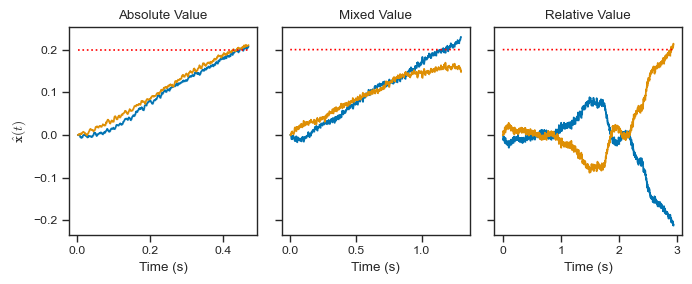

In [58]:
absolute_vs_relative(coherence=0.128, threshold=0.2, perception_seed=0)

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")
C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")
C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


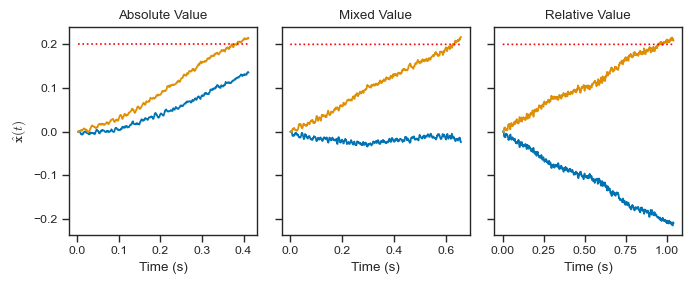

In [59]:
absolute_vs_relative(coherence=0.128, threshold=0.2, perception_seed=1)

In [12]:
def vary_ramp_threshold(coherence,
                   trials=3,
                   nActions=2,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   dt_sample=0.02,
                   ramps=[0.5, 1],
                   thresholds=[0.3, 0.5],
                   relative=0,
                   tmax=5,
                   rA=4,
                   nNeurons=2000,
                   name="vary_ramp_threshold"):

    dfs = []
    inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed)
    inputs.create(coherence=coherence, correct=0)  # force choice "zero" to be correct
    for ramp in ramps:
        for threshold in thresholds:
            for trial in range(trials):
                print(f"trial {trial}, ramp {ramp}, threshold {threshold}")
                net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative, rA=rA, nNeurons=nNeurons)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > tmax:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                correct = 1 if choice==net.inputs.correct else 0
                df = pd.DataFrame()
                df['coherence'] = coherence*np.ones_like(sim.trange())
                df['trial'] = trial*np.ones_like(sim.trange())
                df['threshold'] = threshold*np.ones_like(sim.trange())
                df['ramp'] = ramp*np.ones_like(sim.trange())
                df['dt_sample'] = dt_sample*np.ones_like(sim.trange())
                df['time'] = sim.trange()
                df['accuracy'] = 100*correct*np.ones_like(sim.trange())
                df['RT'] = 1000*RT*np.ones_like(sim.trange())
                for a in range(nActions):
                    df[f'ideal {a}'] = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
                    df[f'evidence {a}'] = sim.data[net.pAccumulator][:,a].ravel()
                    df[f'value {a}'] = sim.data[net.pValue][:,a].ravel()
                dfs.append(df)

    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")
    
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((7.08, 4)))
    for r in range(len(ramps)):
        for t in range(len(thresholds)):
            ramp, threshold = ramps[r], thresholds[t]
            subdata = data.query("ramp==@ramp & threshold==@threshold")
            subdata_correct = subdata.query("accuracy==100")
            subdata_incorrect = subdata.query("accuracy==0")
            if not subdata_correct.empty:
                sns.lineplot(data=subdata_correct, x='time', y='value 0', units='trial', estimator=None, lw=0.2, color=palette2[0], ax=axes[r][t])
            if not subdata_incorrect.empty:
                sns.lineplot(data=subdata_incorrect, x='time', y='value 0', units='trial', estimator=None, lw=0.2, color=palette2[1], ax=axes[r][t])            
            sns.lineplot(data=subdata, x='time', y='ideal 0', color=palette[0], linestyle="--", estimator=None, ax=axes[r][t])
            sns.lineplot(data=subdata, x='time', y='threshold', color="red", linestyle=":", estimator=None, ax=axes[r][t])
            axes[r][t].set(xlabel="Time (s)", ylabel=r"$\hat{\mathbf{x}}(t)$", title=f"ramp {ramp}, threshold {threshold}", ylim=((-0.05, threshold+0.05)))
    axes[0][0].set(ylabel=r"$\hat{\mathbf{x}}(t)$")
    axes[1][0].set(xlabel="Time (s)")
    axes[1][1].set(ylabel=r"$\hat{\mathbf{x}}(t)$", xlabel="Time (s)")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

trial 0, ramp 0.5, threshold 0.3
trial 1, ramp 0.5, threshold 0.3
trial 2, ramp 0.5, threshold 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 3, ramp 0.5, threshold 0.3
trial 4, ramp 0.5, threshold 0.3
trial 5, ramp 0.5, threshold 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 6, ramp 0.5, threshold 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:516: CacheIOWarning: The cache index could not be updated because another program blocked access to it. This is commonly caused by anti-virus software. It is safe to ignore this warning. But if you see it a lot, you might want to consider doing one of the following for the best Nengo performance:
1. Configure your anti-virus to ignore the Nengo cache folder ('C:\Users\Peter Duggins\.nengo\cache\decoders').
2. Disable the cache.

  warnings.warn(


trial 7, ramp 0.5, threshold 0.3
trial 8, ramp 0.5, threshold 0.3
trial 9, ramp 0.5, threshold 0.3
trial 10, ramp 0.5, threshold 0.3
trial 11, ramp 0.5, threshold 0.3
trial 12, ramp 0.5, threshold 0.3
trial 13, ramp 0.5, threshold 0.3
trial 14, ramp 0.5, threshold 0.3
trial 15, ramp 0.5, threshold 0.3
trial 16, ramp 0.5, threshold 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:516: CacheIOWarning: The cache index could not be updated because another program blocked access to it. This is commonly caused by anti-virus software. It is safe to ignore this warning. But if you see it a lot, you might want to consider doing one of the following for the best Nengo performance:
1. Configure your anti-virus to ignore the Nengo cache folder ('C:\Users\Peter Duggins\.nengo\cache\decoders').
2. Disable the cache.

  warnings.warn(


trial 17, ramp 0.5, threshold 0.3
trial 18, ramp 0.5, threshold 0.3
trial 19, ramp 0.5, threshold 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 20, ramp 0.5, threshold 0.3
trial 21, ramp 0.5, threshold 0.3
trial 22, ramp 0.5, threshold 0.3
trial 23, ramp 0.5, threshold 0.3
trial 24, ramp 0.5, threshold 0.3
trial 25, ramp 0.5, threshold 0.3
trial 26, ramp 0.5, threshold 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 27, ramp 0.5, threshold 0.3
trial 28, ramp 0.5, threshold 0.3
trial 29, ramp 0.5, threshold 0.3
trial 0, ramp 0.5, threshold 0.5
trial 1, ramp 0.5, threshold 0.5
trial 2, ramp 0.5, threshold 0.5
trial 3, ramp 0.5, threshold 0.5
trial 4, ramp 0.5, threshold 0.5
trial 5, ramp 0.5, threshold 0.5
trial 6, ramp 0.5, threshold 0.5
trial 7, ramp 0.5, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 8, ramp 0.5, threshold 0.5
trial 9, ramp 0.5, threshold 0.5
trial 10, ramp 0.5, threshold 0.5
trial 11, ramp 0.5, threshold 0.5
trial 12, ramp 0.5, threshold 0.5
trial 13, ramp 0.5, threshold 0.5
trial 14, ramp 0.5, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 15, ramp 0.5, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 16, ramp 0.5, threshold 0.5
trial 17, ramp 0.5, threshold 0.5
trial 18, ramp 0.5, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 19, ramp 0.5, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 20, ramp 0.5, threshold 0.5
trial 21, ramp 0.5, threshold 0.5
trial 22, ramp 0.5, threshold 0.5
trial 23, ramp 0.5, threshold 0.5
trial 24, ramp 0.5, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 25, ramp 0.5, threshold 0.5
trial 26, ramp 0.5, threshold 0.5
trial 27, ramp 0.5, threshold 0.5
trial 28, ramp 0.5, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 29, ramp 0.5, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 0, ramp 1, threshold 0.3
trial 1, ramp 1, threshold 0.3
trial 2, ramp 1, threshold 0.3
trial 3, ramp 1, threshold 0.3
trial 4, ramp 1, threshold 0.3
trial 5, ramp 1, threshold 0.3
trial 6, ramp 1, threshold 0.3
trial 7, ramp 1, threshold 0.3
trial 8, ramp 1, threshold 0.3
trial 9, ramp 1, threshold 0.3
trial 10, ramp 1, threshold 0.3
trial 11, ramp 1, threshold 0.3
trial 12, ramp 1, threshold 0.3
trial 13, ramp 1, threshold 0.3
trial 14, ramp 1, threshold 0.3
trial 15, ramp 1, threshold 0.3
trial 16, ramp 1, threshold 0.3
trial 17, ramp 1, threshold 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:516: CacheIOWarning: The cache index could not be updated because another program blocked access to it. This is commonly caused by anti-virus software. It is safe to ignore this warning. But if you see it a lot, you might want to consider doing one of the following for the best Nengo performance:
1. Configure your anti-virus to ignore the Nengo cache folder ('C:\Users\Peter Duggins\.nengo\cache\decoders').
2. Disable the cache.

  warnings.warn(


trial 18, ramp 1, threshold 0.3
trial 19, ramp 1, threshold 0.3
trial 20, ramp 1, threshold 0.3
trial 21, ramp 1, threshold 0.3
trial 22, ramp 1, threshold 0.3
trial 23, ramp 1, threshold 0.3
trial 24, ramp 1, threshold 0.3
trial 25, ramp 1, threshold 0.3
trial 26, ramp 1, threshold 0.3
trial 27, ramp 1, threshold 0.3
trial 28, ramp 1, threshold 0.3
trial 29, ramp 1, threshold 0.3
trial 0, ramp 1, threshold 0.5
trial 1, ramp 1, threshold 0.5
trial 2, ramp 1, threshold 0.5
trial 3, ramp 1, threshold 0.5
trial 4, ramp 1, threshold 0.5
trial 5, ramp 1, threshold 0.5
trial 6, ramp 1, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 7, ramp 1, threshold 0.5
trial 8, ramp 1, threshold 0.5
trial 9, ramp 1, threshold 0.5
trial 10, ramp 1, threshold 0.5
trial 11, ramp 1, threshold 0.5
trial 12, ramp 1, threshold 0.5
trial 13, ramp 1, threshold 0.5
trial 14, ramp 1, threshold 0.5
trial 15, ramp 1, threshold 0.5
trial 16, ramp 1, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 17, ramp 1, threshold 0.5
trial 18, ramp 1, threshold 0.5
trial 19, ramp 1, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 20, ramp 1, threshold 0.5
trial 21, ramp 1, threshold 0.5
trial 22, ramp 1, threshold 0.5
trial 23, ramp 1, threshold 0.5
trial 24, ramp 1, threshold 0.5
trial 25, ramp 1, threshold 0.5
trial 26, ramp 1, threshold 0.5
trial 27, ramp 1, threshold 0.5
trial 28, ramp 1, threshold 0.5
trial 29, ramp 1, threshold 0.5


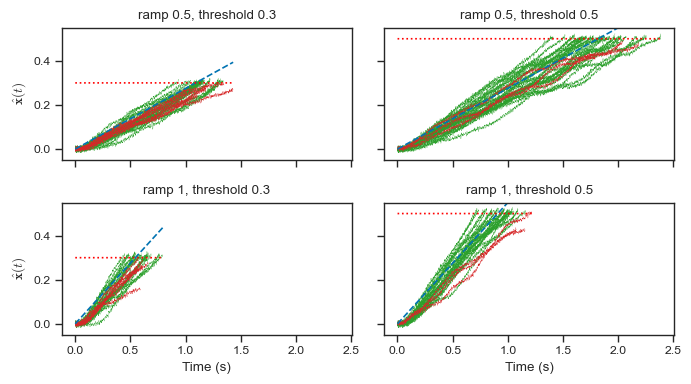

In [13]:
vary_ramp_threshold(coherence=0.1, trials=30)

In [7]:
def scan_coherence(
        coherences=[0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512],
        ramp=1,
        threshold=0.5,
        sigma=0.3,
        nActions=2,
        nNeurons=200,
        trials=3,
        perception_seed=0,
        dt=0.001,
        dt_sample=0.01,
        relative=0,
        load=False,
        error=('ci', 95),  # ("pi", 50),
        tmax=10,
        condition='normal',  # just for labelling data and plotting empirical validation
        name="scan_coherence"):
    
    if not load:
        network_seed = 0
        columns = ('type', 'name', 'trial', 'coherence', 'RT', 'accuracy', 'condition')  # same as Palmer dataframe
        dfs = []
        for c, coherence in enumerate(coherences):
            inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=int(1000*coherence), sigma=sigma)
            print(f"coherence {coherence}")
            for trial in range(trials):
                # print(f"trial {trial}, coherence {coherence}")
                inputs.create(coherence=coherence)
                net = build_network(inputs, nActions=nActions, nNeurons=nNeurons, seed=trial, ramp=ramp, threshold=threshold, relative=relative)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > tmax:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                correct = True if choice==inputs.correct else False
                # print(RT, 100*correct)
                label = f"ramp {ramp}, thr {threshold}"
                dfs.append(pd.DataFrame([['model', '0', trial, 100*coherence, RT, 100*correct, condition]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{name}.pkl")
    else:
        data = pd.read_pickle(f"data/{name}.pkl")

    palmer = pd.read_pickle('data/palmer2005.pkl').query("name=='JP' & condition==@condition")
    combined = pd.concat([palmer, data])
    # for coherence in combined['coherence'].unique():
    #     rts_sim = combined.query("coherence==@coherence & type=='model'")['RT'].to_numpy()
    #     rts_emp = combined.query("coherence==@coherence & type=='human'")['RT'].to_numpy()
    #     print(f"coherence {coherence}, mean sim {np.mean(rts_sim)}, mean emp {np.mean(rts_emp)}")

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=((7.08, 2)))
    sns.lineplot(data=combined, x='coherence', y='RT', hue='type', style="type", palette=palette[:2], markers=True, errorbar=error, ax=axes[0])
    sns.lineplot(data=combined, x='coherence', y='accuracy', hue="type", style="type", palette=palette[:2], markers=True, ax=axes[1])  # errorbar=error,
    axes[0].set(xlabel="Coherence (%)", ylabel="Response Time (s)")
    axes[0].set_xscale('log')
    axes[1].set(xlabel="Coherence (%)", xlim=((0.5, 100)), ylabel="Accuracy (%)", ylim=((45, 105)), yticks=((50, 60, 70, 80, 90, 100)))
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/compare_palmer_model.svg")
    fig.savefig(f"plots/compare_palmer_model.png", dpi=600)

    if condition=="speed":
        bins = np.arange(0.0, 1.0, 0.1)
    if condition=="normal":
        bins = np.arange(0.0, 2.0, 0.2)
    if condition=="accuracy":
        bins = np.arange(0.0, 4.0, 0.4)
    fig = sns.FacetGrid(combined, col="coherence", hue='type', palette=palette[:2], height=1.5, aspect=1.5, col_wrap=4, sharex=True)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    fig.savefig(f"plots/compare_palmer_model_RTs.svg")
    fig.savefig(f"plots/compare_palmer_model_RTs.png", dpi=600)

coherence 0.008
coherence 0.016
coherence 0.032
coherence 0.064
coherence 0.128
coherence 0.256
coherence 0.512


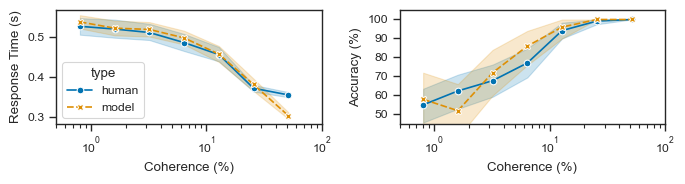

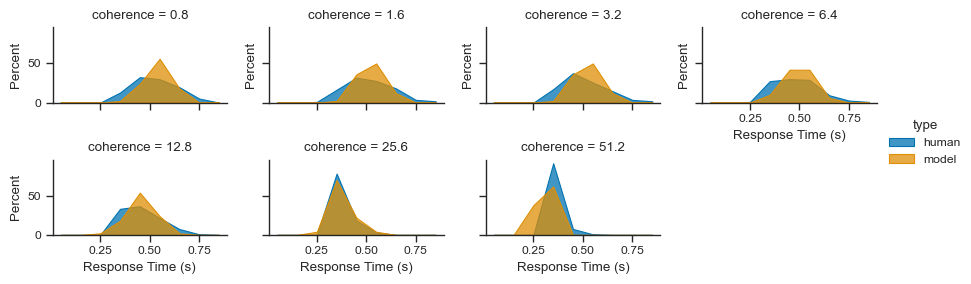

In [6]:
scan_coherence(ramp=1.6, threshold=0.2, relative=0.5, trials=50, name="sigma3", condition="speed", nNeurons=200, dt_sample=0.01, sigma=0.3, load=False)

coherence 0.008
coherence 0.016
coherence 0.032
coherence 0.064
coherence 0.128
coherence 0.256
coherence 0.512


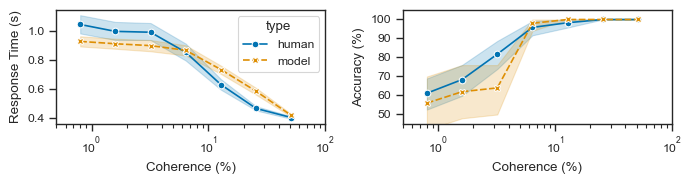

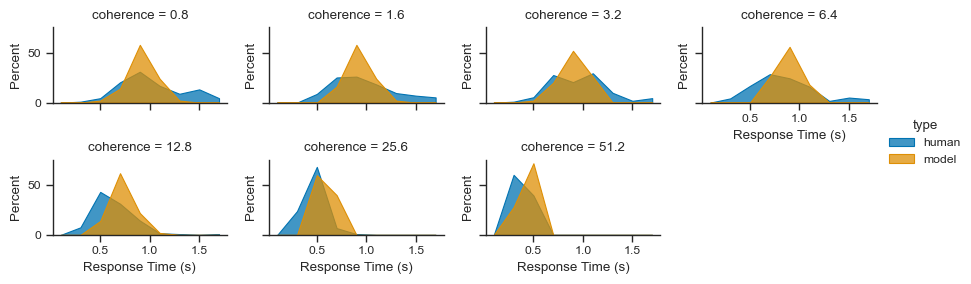

In [15]:
scan_coherence(ramp=1.6, threshold=0.3, relative=0.6, trials=50, name="sigma_normal", condition="normal", nNeurons=200, dt_sample=0.01, sigma=0.3, load=False)

coherence 0.008
coherence 0.016
coherence 0.032
coherence 0.064
coherence 0.128
coherence 0.256
coherence 0.512


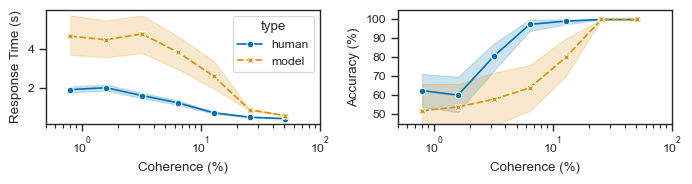

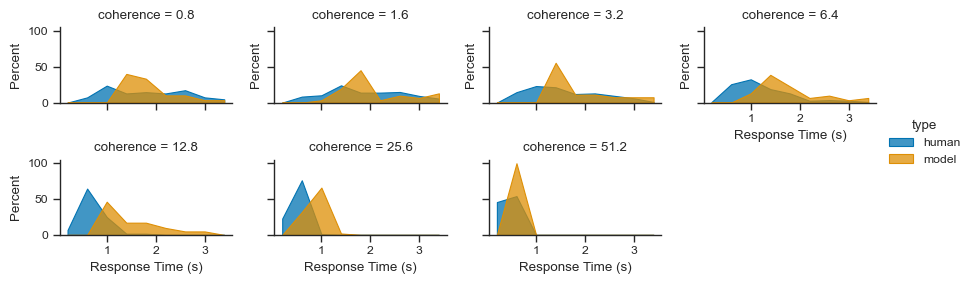

In [16]:
scan_coherence(ramp=1.5, threshold=0.4, relative=0.7, trials=50, name="sigma_accuracy", condition="accuracy", nNeurons=200, dt_sample=0.01, sigma=0.3, load=False)

In [14]:
def scan_coherence_ramp_threshold(
        coherences=np.geomspace(0.01, 1.0, 5),
        ramps=[0.5, 1.0],
        thresholds=[0.3, 0.6],
        nActions=2,
        trials=3,
        perception_seed=0,
        dt=0.001,
        dt_sample=0.02,
        relative=0,
        load=False,
        errbar="se",
        tmax=5,
        RTmin=0.2,
        name="scan_coherence_ramp_threshold"):
    
    if not load:
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed)
        network_seed = 0
        columns = ('label', 'ramp', 'threshold', 'coherence', 'trial', 'RT', 'accuracy')
        dfs = []
        for ramp in ramps:
            for threshold in thresholds:
                for coherence in coherences:
                    for trial in range(trials):
                        print(f"trial {trial}, coherence {coherence}, ramp {ramp}, threshold {threshold}")
                        network_seed += 1
                        inputs.create(coherence=coherence)
                        net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative)
                        sim = nengo.Simulator(net, progress_bar=False)
                        choice = None
                        while choice==None:
                            sim.run(dt)
                            if np.any(sim.data[net.pAction][-1,:] > 0):
                                choice = np.argmax(sim.data[net.pAction][-1,:])
                                RT = sim.trange()[-1]
                            if sim.trange()[-1] > tmax:
                                choice = np.argmax(sim.data[net.pValue][-1,:])
                                RT = sim.trange()[-1]
                        correct = True if choice==inputs.correct else False
                        if RT > RTmin:
                            label = f"ramp {ramp}, thr {threshold}"
                            dfs.append(pd.DataFrame([[label, ramp, threshold, 100*coherence, trial, RT, 100*correct]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{name}.pkl")
    else:
        data = pd.read_pickle(f"data/{name}.pkl")
    
    fig, axes = plt.subplots(nrows=len(ramps), ncols=len(thresholds), sharex=True, sharey=True, figsize=((7.08, 2*len(ramps))))
    for r in range(len(ramps)):
        for t in range(len(thresholds)):
            ramp, threshold = ramps[r], thresholds[t]
            sns.lineplot(data=data.query("ramp==@ramp & threshold==@threshold"), x='coherence', y='RT', errorbar=errbar, ax=axes[r][t])
            axes[r][t].set(title=f"ramp {ramp}, threshold {threshold}")
    for r in range(len(ramps)):
        axes[r][0].set(ylabel="Response Times (s)")
    for t in range(len(thresholds)):
        axes[len(ramps)-1][t].set(xlabel="Coherence (% motion strength)")
    plt.xscale('log')
    plt.tight_layout()
    fig.savefig(f"plots/{name}_RT.svg")
    fig.savefig(f"plots/{name}_RT.png", dpi=600)

    fig, axes = plt.subplots(nrows=len(ramps), ncols=len(thresholds), sharex=True, sharey=True, figsize=((7.08, 2*len(ramps))))
    for r in range(len(ramps)):
        for t in range(len(thresholds)):
            ramp, threshold = ramps[r], thresholds[t]
            sns.lineplot(data=data.query("ramp==@ramp & threshold==@threshold"), x='coherence', y='accuracy', errorbar=errbar, ax=axes[r][t])
            axes[r][t].set(title=f"ramp {ramp}, threshold {threshold}")
    for r in range(len(ramps)):
        axes[r][0].set(ylabel="Accuracy (%)")
    for t in range(len(thresholds)):
        axes[len(ramps)-1][t].set(xlabel="Coherence (% motion strength)")
    plt.xscale('log')
    plt.tight_layout()
    fig.savefig(f"plots/{name}_accuracy.svg")
    fig.savefig(f"plots/{name}_accuracy.png", dpi=600)

    fig = sns.FacetGrid(data, row="coherence", hue="label", palette=palette, height=1.15, aspect=3)
    fig.map_dataframe(sns.histplot, x="RT", stat='probability', element="poly", bins=np.arange(0.2, 2.6, 0.2), common_norm=False)
    fig.set_xlabels("Reaction Time (s)")
    fig.add_legend()
    fig.savefig(f"plots/{name}_distributions.svg")
    fig.savefig(f"plots/{name}_distributions.png", dpi=600)

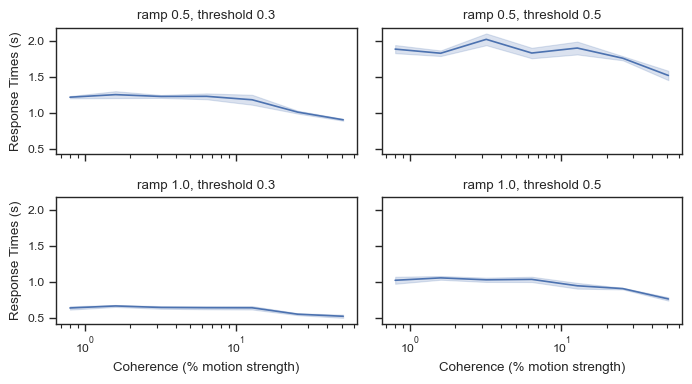

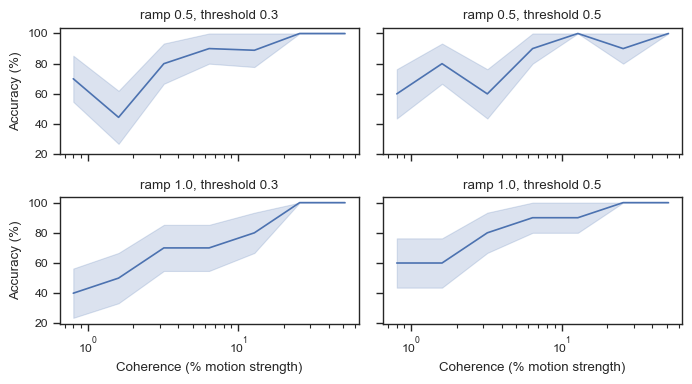

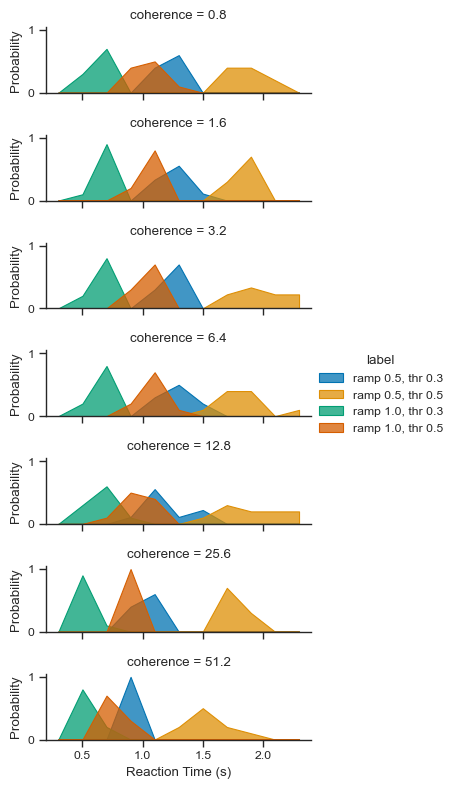

In [15]:
scan_coherence_ramp_threshold(
        load=True,
        coherences=[0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512],
        ramps=[0.5, 1.0],
        thresholds=[0.3, 0.5],
        trials=10)

In [18]:
def scan_coherence_nActions(
        coherences=np.geomspace(0.01, 1.0, 5),
        nActions_list=[2, 4],
        ramp=1.0,
        threshold=0.5,
        trials=3,
        perception_seed=0,
        network_seed=0,
        dt=0.001,
        dt_sample=0.02,
        relative=0,
        load=False,
        tmax=5,
        RTmin=0.2,
        name="scan_coherence_nActions"):
    
    if not load:
        columns = ('nActions', 'coherence', 'trial', 'RT', 'accuracy')
        dfs = []
        for nActions in nActions_list:
            inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed)
            for coherence in coherences:
                for trial in range(trials):
                    print(f"trial {trial}, coherence {coherence}, nActions {nActions}")
                    network_seed += 1
                    inputs.create(coherence=coherence)
                    net = build_network(inputs, nActions=nActions, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > tmax:
                            choice = np.argmax(sim.data[net.pValue][-1,:])
                            RT = sim.trange()[-1]
                    correct = True if choice==inputs.correct else False
                    if RT > RTmin:
                        dfs.append(pd.DataFrame([[f"{nActions}", 100*coherence, trial, RT, 100*correct]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{name}.pkl")
    else:
        data = pd.read_pickle(f"data/{name}.pkl")
    
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=data, x='coherence', y='RT', hue='nActions', ax=axes[0])
    sns.lineplot(data=data, x='coherence', y='accuracy', hue='nActions', ax=axes[1])
    axes[0].set(ylabel="Response Times (s)")
    axes[1].set(ylabel="Accuracy (%)", xlabel="Coherence (% motion strength)")
    plt.xscale('log')
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/{name}_RT.svg")
    fig.savefig(f"plots/{name}_RT.png", dpi=600)

    palette3 = sns.color_palette("viridis", len(coherences))
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=((7.08, 3)))
    sns.histplot(data=data.query("nActions=='2'"), x="RT", hue="coherence", stat='probability', element="poly",
                 bins=np.arange(0.2, 1.6, 0.1), common_norm=False, palette=palette3, ax=axes[0])
    sns.histplot(data=data.query("nActions=='4'"), x="RT", hue="coherence", stat='probability', element="poly",
                 bins=np.arange(0.2, 1.6, 0.1), common_norm=False, palette=palette3, ax=axes[1])
    axes[0].set(xlabel='Response Time (s)', ylabel="Probability", title='2 Actions')
    axes[1].set(title='4 Actions')
    plt.tight_layout()
    fig.savefig(f"plots/{name}_distributions.svg")
    fig.savefig(f"plots/{name}_distributions.png", dpi=600)

trial 0, coherence 0.008, nActions 2
trial 1, coherence 0.008, nActions 2
trial 2, coherence 0.008, nActions 2
trial 3, coherence 0.008, nActions 2
trial 4, coherence 0.008, nActions 2
trial 5, coherence 0.008, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 6, coherence 0.008, nActions 2
trial 7, coherence 0.008, nActions 2
trial 8, coherence 0.008, nActions 2
trial 9, coherence 0.008, nActions 2
trial 10, coherence 0.008, nActions 2
trial 11, coherence 0.008, nActions 2
trial 12, coherence 0.008, nActions 2
trial 13, coherence 0.008, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:516: CacheIOWarning: The cache index could not be updated because another program blocked access to it. This is commonly caused by anti-virus software. It is safe to ignore this warning. But if you see it a lot, you might want to consider doing one of the following for the best Nengo performance:
1. Configure your anti-virus to ignore the Nengo cache folder ('C:\Users\Peter Duggins\.nengo\cache\decoders').
2. Disable the cache.

  warnings.warn(


trial 14, coherence 0.008, nActions 2
trial 15, coherence 0.008, nActions 2
trial 16, coherence 0.008, nActions 2
trial 17, coherence 0.008, nActions 2
trial 18, coherence 0.008, nActions 2
trial 19, coherence 0.008, nActions 2
trial 20, coherence 0.008, nActions 2
trial 21, coherence 0.008, nActions 2
trial 22, coherence 0.008, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 23, coherence 0.008, nActions 2
trial 24, coherence 0.008, nActions 2
trial 25, coherence 0.008, nActions 2
trial 26, coherence 0.008, nActions 2
trial 27, coherence 0.008, nActions 2
trial 28, coherence 0.008, nActions 2
trial 29, coherence 0.008, nActions 2
trial 0, coherence 0.016, nActions 2
trial 1, coherence 0.016, nActions 2
trial 2, coherence 0.016, nActions 2
trial 3, coherence 0.016, nActions 2
trial 4, coherence 0.016, nActions 2
trial 5, coherence 0.016, nActions 2
trial 6, coherence 0.016, nActions 2
trial 7, coherence 0.016, nActions 2
trial 8, coherence 0.016, nActions 2
trial 9, coherence 0.016, nActions 2
trial 10, coherence 0.016, nActions 2
trial 11, coherence 0.016, nActions 2
trial 12, coherence 0.016, nActions 2
trial 13, coherence 0.016, nActions 2
trial 14, coherence 0.016, nActions 2
trial 15, coherence 0.016, nActions 2
trial 16, coherence 0.016, nActions 2
trial 17, coherence 0.016, nActions 2
trial 18, coherence 0.016, nActions 2
trial 19, coherence 0.

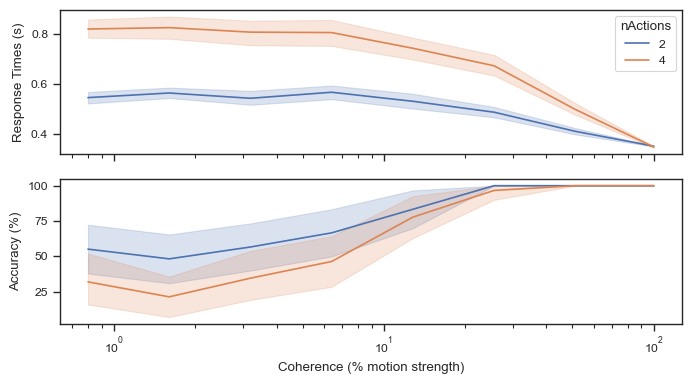

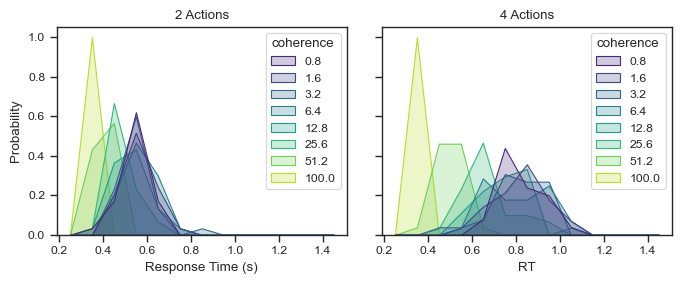

In [19]:
scan_coherence_nActions(load=False, coherences=[0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0], threshold=0.25, trials=30)